In [1]:
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from sbi_lens.config import config_lsst_y_10
from nn import MomentNetwork

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#load dataset 

dataset = np.load(
    "./data/LOADED&COMPRESSED_year_10_with_noise_score_conditional_very_large.npz",
    allow_pickle=True,
)["arr_0"]


inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])
dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)

# train set
dataset_y_train = dataset_y[:len(dataset_score) - 2000]
dataset_score_train = dataset_score[:len(dataset_score) - 2000]
dataset_theta_train = dataset_theta[:len(dataset_score) - 2000]

# test set
dataset_y_test = dataset_y[len(dataset_score) - 2000:]
dataset_score_test = dataset_score[len(dataset_score) - 2000:]
dataset_theta_test = dataset_theta[len(dataset_score) - 2000:]

In [4]:
# training info 

total_steps = 5_000_000
sbi_method = 'nle'
batch_size = 256
params_name = config_lsst_y_10.params_name_latex

## Learn Marginal Score

In [5]:
nb_layer = 2

get_moments = hk.without_apply_rng(
    hk.transform_with_state(
        lambda theta, y : MomentNetwork(
            layers = [256]* nb_layer, 
            batch_norm = [hk.BatchNorm(True, True, 0.999) for i in range(nb_layer)]
        )(theta, y, is_training=True)
    )
)


get_moments_fixed = hk.without_apply_rng(
    hk.transform_with_state(
        lambda theta, y : MomentNetwork(
            layers = [256]* nb_layer, 
            batch_norm = [hk.BatchNorm(True, True, 0.999) for i in range(nb_layer)]
        )(theta, y, is_training=False)
    )
)

In [7]:
# loss and update functions 

@jax.jit
def loss_esperance(params, state_bn, theta, y, score):

  out, state_bn = get_moments.apply(params, state_bn, theta, y)

  return jnp.sum((out - score) ** 2, axis=-1).mean() / 1000, state_bn


@jax.jit
def update_esperance(params, opt_state, state_bn, theta, y, score):
    """Single SGD update step."""
    (loss, state_bn), grads = jax.value_and_grad(loss_esperance, has_aux = True)(
        params, state_bn, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state, state_bn

In [8]:
# training 

# init params
rng_seq = hk.PRNGSequence(12)
params_esperance, state_bn = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

# learning rate and optimizer
nb_steps = total_steps - total_steps * 0.5
lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 60,
        decay_rate=0.9,
        end_value=1e-6,
    )
optimizer = optax.adam(lr_scheduler)
opt_state_esperance = optimizer.init(params_esperance)


batch_loss = []
val_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

# training loop
for batch in pbar:
    
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    inds2 = np.random.randint(0, len(dataset_score_test), batch_size)
    
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_esperance, opt_state_esperance, state_bn = update_esperance(
        params_esperance, opt_state_esperance, state_bn, ex_theta, ex_y, ex_score
    )

    if batch % 500 == 0:
        batch_loss.append(l)
        val_loss.append(
          loss_esperance(
              params_esperance, 
              state_bn,
              dataset_theta_test[inds2], 
              dataset_y_test[inds2],
              dataset_score_test[inds2]
          )[0]
        )
        lr_scheduler_store.append(lr_scheduler(batch))
        pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 503.422: 100%|██████████| 5000001/5000001 [58:54<00:00, 1414.50it/s] 


In [9]:
# save NN params

with open(
   "./data/SNR_study/params_esp.pkl", "wb"
) as fp:
    pickle.dump(params_esperance, fp)

with open(
   "./data/SNR_study/state_bn_esp.pkl", "wb"
) as fp:
    pickle.dump(state_bn, fp)

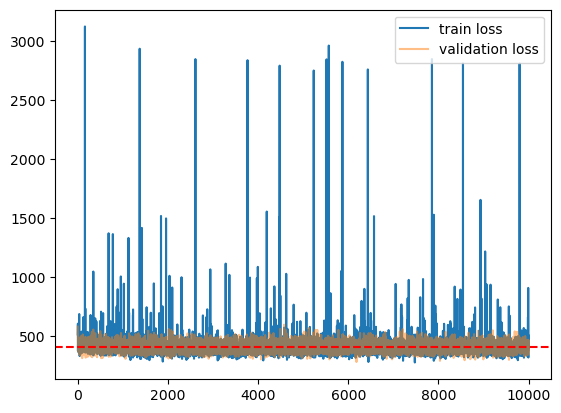

In [10]:
# plot losses

plt.plot(batch_loss, label = 'train loss')
plt.plot(val_loss, alpha = 0.5, label = 'validation loss')
plt.axhline(410, linestyle = '--', c = 'red')
plt.legend()

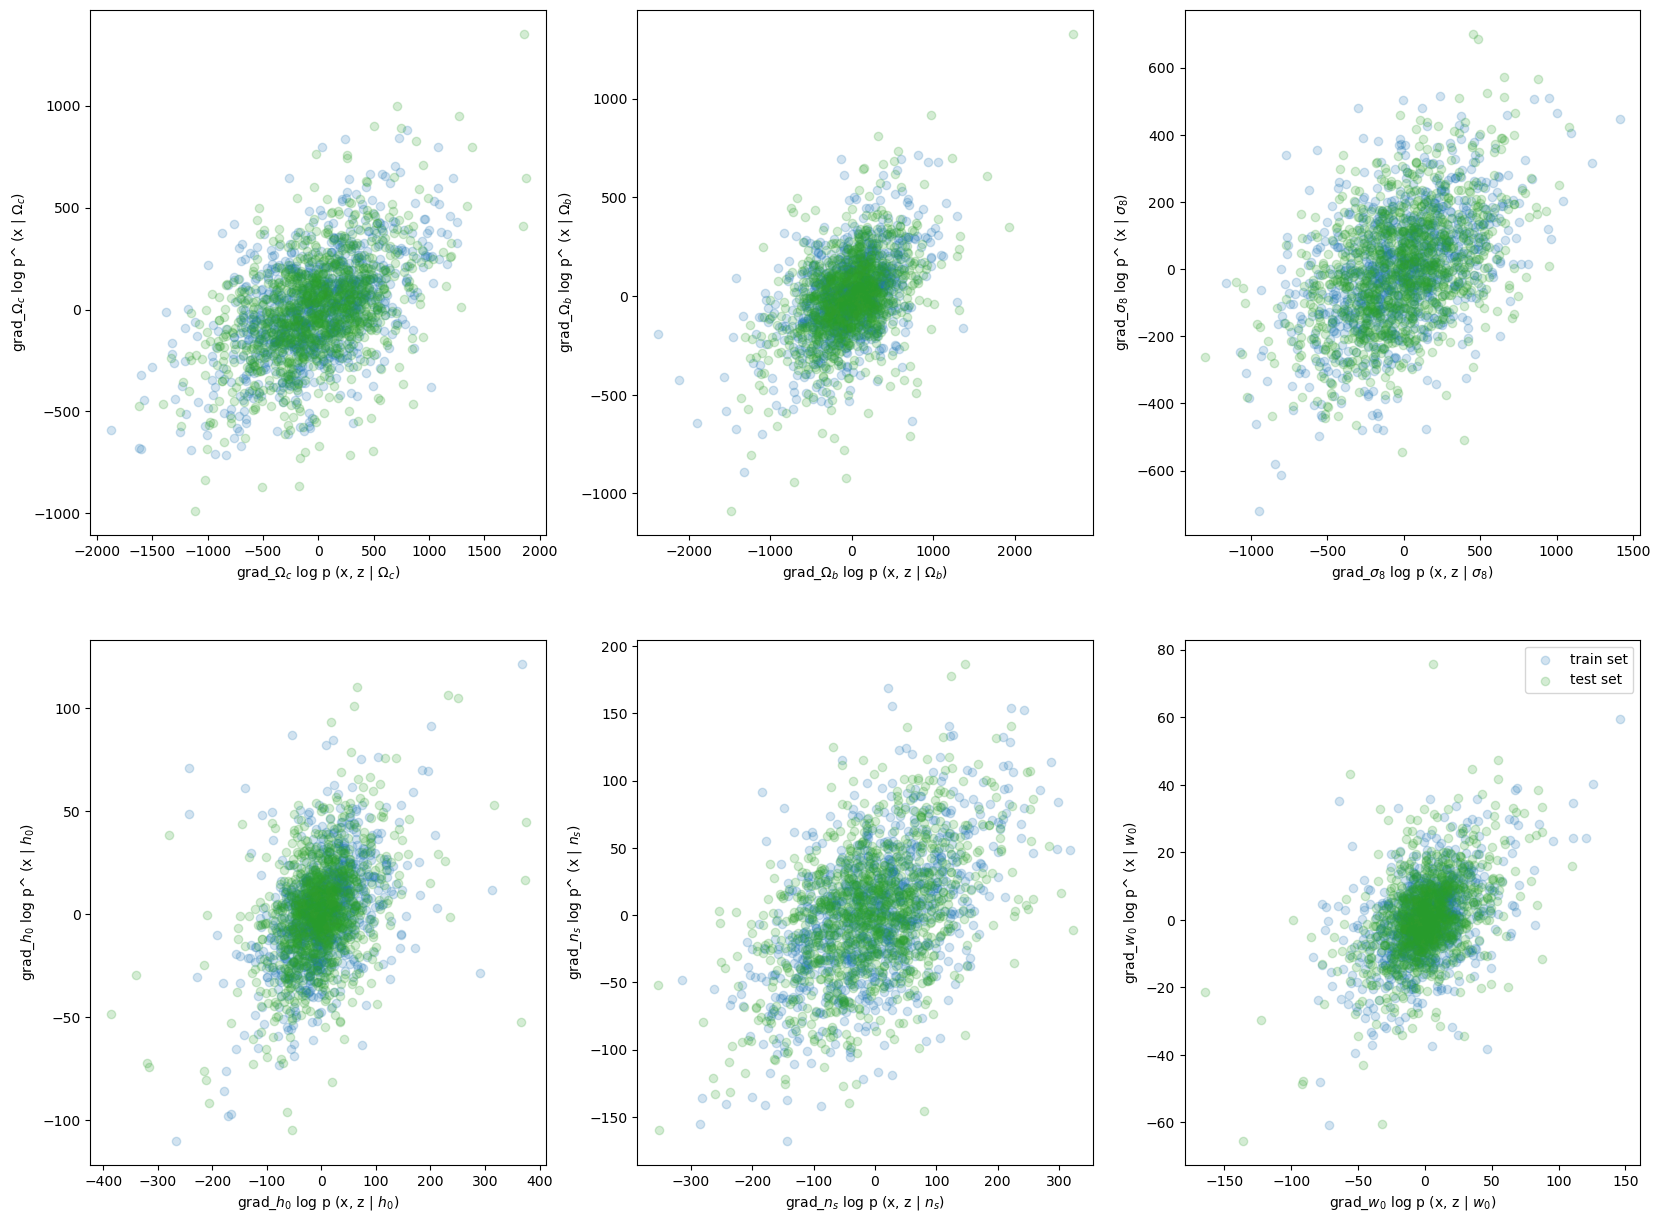

In [11]:
# check regression 

prediction1, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_test[:1000],
    dataset_y_test[:1000]
)

prediction2, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_train[:1000],
    dataset_y_train[:1000]
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_train[:1000][...,i], prediction2[...,i], alpha = 0.2, label = 'train set')
  plt.scatter(dataset_score_test[:1000][...,i], prediction1[...,i], alpha = 0.2, color = 'C2', marker = 'o', label = 'test set')
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.legend()

In [6]:
a_file =  open(
   "./data/SNR_study/params_esp.pkl", "rb"
) 

params_esperance = pickle.load(a_file)
    
a_file = open(
   "./data/SNR_study/state_bn_esp.pkl", "rb"
) 

state_bn = pickle.load(a_file)

## Check with $\nabla$ nle

In [ ]:
# train NLE with "infinite" number of simulations 

from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from snle import SNLE
from tqdm import tqdm

dim = 6

# buil nde
bijector_layers = [128] * 2

bijector = partial(AffineCoupling, layers=bijector_layers, activation=jax.nn.silu)

NF = partial(ConditionalRealNVP, n_layers=4, bijector_fn=bijector)

class NDE(hk.Module):
    def __call__(self, y):
        return NF(6)(y)

    
nf_log_prob = hk.without_apply_rng(
        hk.transform(lambda theta, y: NDE()(theta).log_prob(y).squeeze())
    )

# init nde
params_init = nf_log_prob.init(
    jax.random.PRNGKey(0), 0.5 * jnp.ones([1, dim]), 0.5 * jnp.ones([1, dim])
)

nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-5,
)
   
inference = SNLE(NDE=nf_log_prob, init_params_nde=params_init, dim=dim)

data = {"theta": dataset_theta, "y": dataset_y}

inference.train(
    data,
    total_steps=70_000,
    batch_size=128,
    score_weight=0,
    learning_rate=lr_scheduler
)

nb of simulations used for training:  452589
... start training


loss -9.282:  82%|████████▏ | 57499/70000 [02:07<00:31, 395.13it/s] 

Text(0.5, 1.0, 'loss nle')

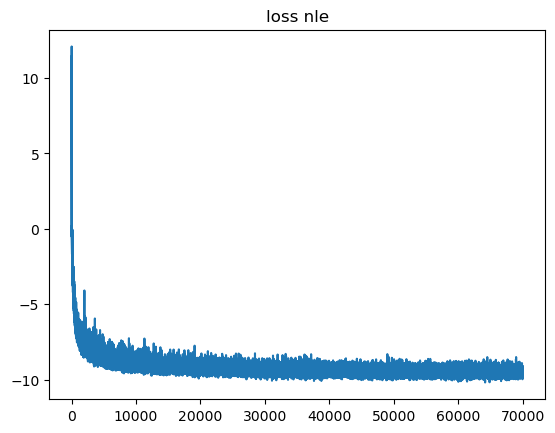

In [13]:
plt.plot(inference.loss[10:])
plt.title('loss nle')

... running hmc
done ✓


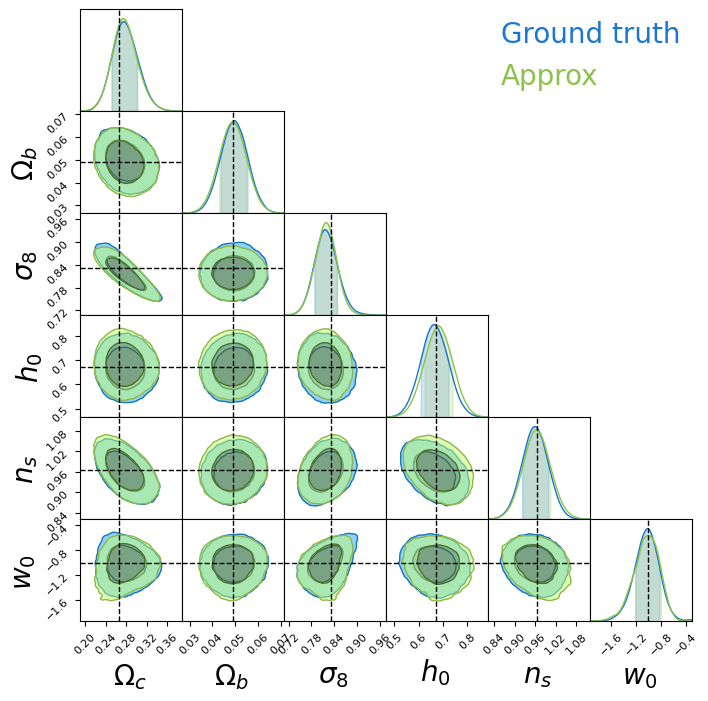

In [20]:
# check approximated posterior 

from utils import make_plot
from lensing_simulator_utils import CompressedSimulator
from sbi_lens.simulator.LogNormal_field import lensingLogNormal
from haiku._src.nets.resnet import ResNet18

N = config_lsst_y_10.N
map_size = config_lsst_y_10.map_size
sigma_e = config_lsst_y_10.sigma_e
gals_per_arcmin2 = config_lsst_y_10.gals_per_arcmin2
nbins = config_lsst_y_10.nbins
a = config_lsst_y_10.a
b = config_lsst_y_10.b
z0 = config_lsst_y_10.z0

truth = config_lsst_y_10.truth

params_name = config_lsst_y_10.params_name_latex

dim = 6

model = partial(
    lensingLogNormal,
    N=N,
    map_size=map_size,
    gal_per_arcmin2=gals_per_arcmin2,
    sigma_e=sigma_e,
    nbins=nbins,
    a=a,
    b=b,
    z0=z0,
    model_type="lognormal",
    lognormal_shifts="LSSTY10",
    with_noise=True,
)


compressor = hk.transform_with_state(lambda y: ResNet18(dim)(y, is_training=False))

a_file = open(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/params_compressor/opt_state_resnet_vmim.pkl",
    "rb",
)
opt_state_resnet = pickle.load(a_file)

a_file = open(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/params_compressor/params_nd_compressor_vmim.pkl",
    "rb",
)
parameters_compressor = pickle.load(a_file)

m_data = jnp.load(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/m_data__256N_10ms_27gpa_0.26se.npy"
)

m_data_comressed, _ = compressor.apply(
    parameters_compressor, opt_state_resnet, None, m_data.reshape([1, N, N, nbins])
)


compressed_simulator = CompressedSimulator(
    model=model,
    score_type='conditional',
    compressor=compressor,
    params_compressor=parameters_compressor,
    opt_state=opt_state_resnet,
)


init_mcmc = jnp.array(jnp.mean(compressed_simulator.prior_sample((1000,), jax.random.PRNGKey(78)), axis = 0))

posterior_sample = inference.sample(
    log_prob_prior=compressed_simulator.prior_log_prob,
    init_point=init_mcmc,
    observation=m_data_comressed,
    key=jax.random.PRNGKey(0),
)
      
sample_ff = jnp.load(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy"
)

make_plot(
    [sample_ff, posterior_sample],
    ["Ground truth", "Approx"],
    params_name,
    truth
)

In [16]:
# looks okay

In [23]:
@jax.vmap
def get_marginal_score(theta, y): 
    score = jax.grad(inference.log_prob_fn, argnums=1)(inference.params, theta, y)
    return score

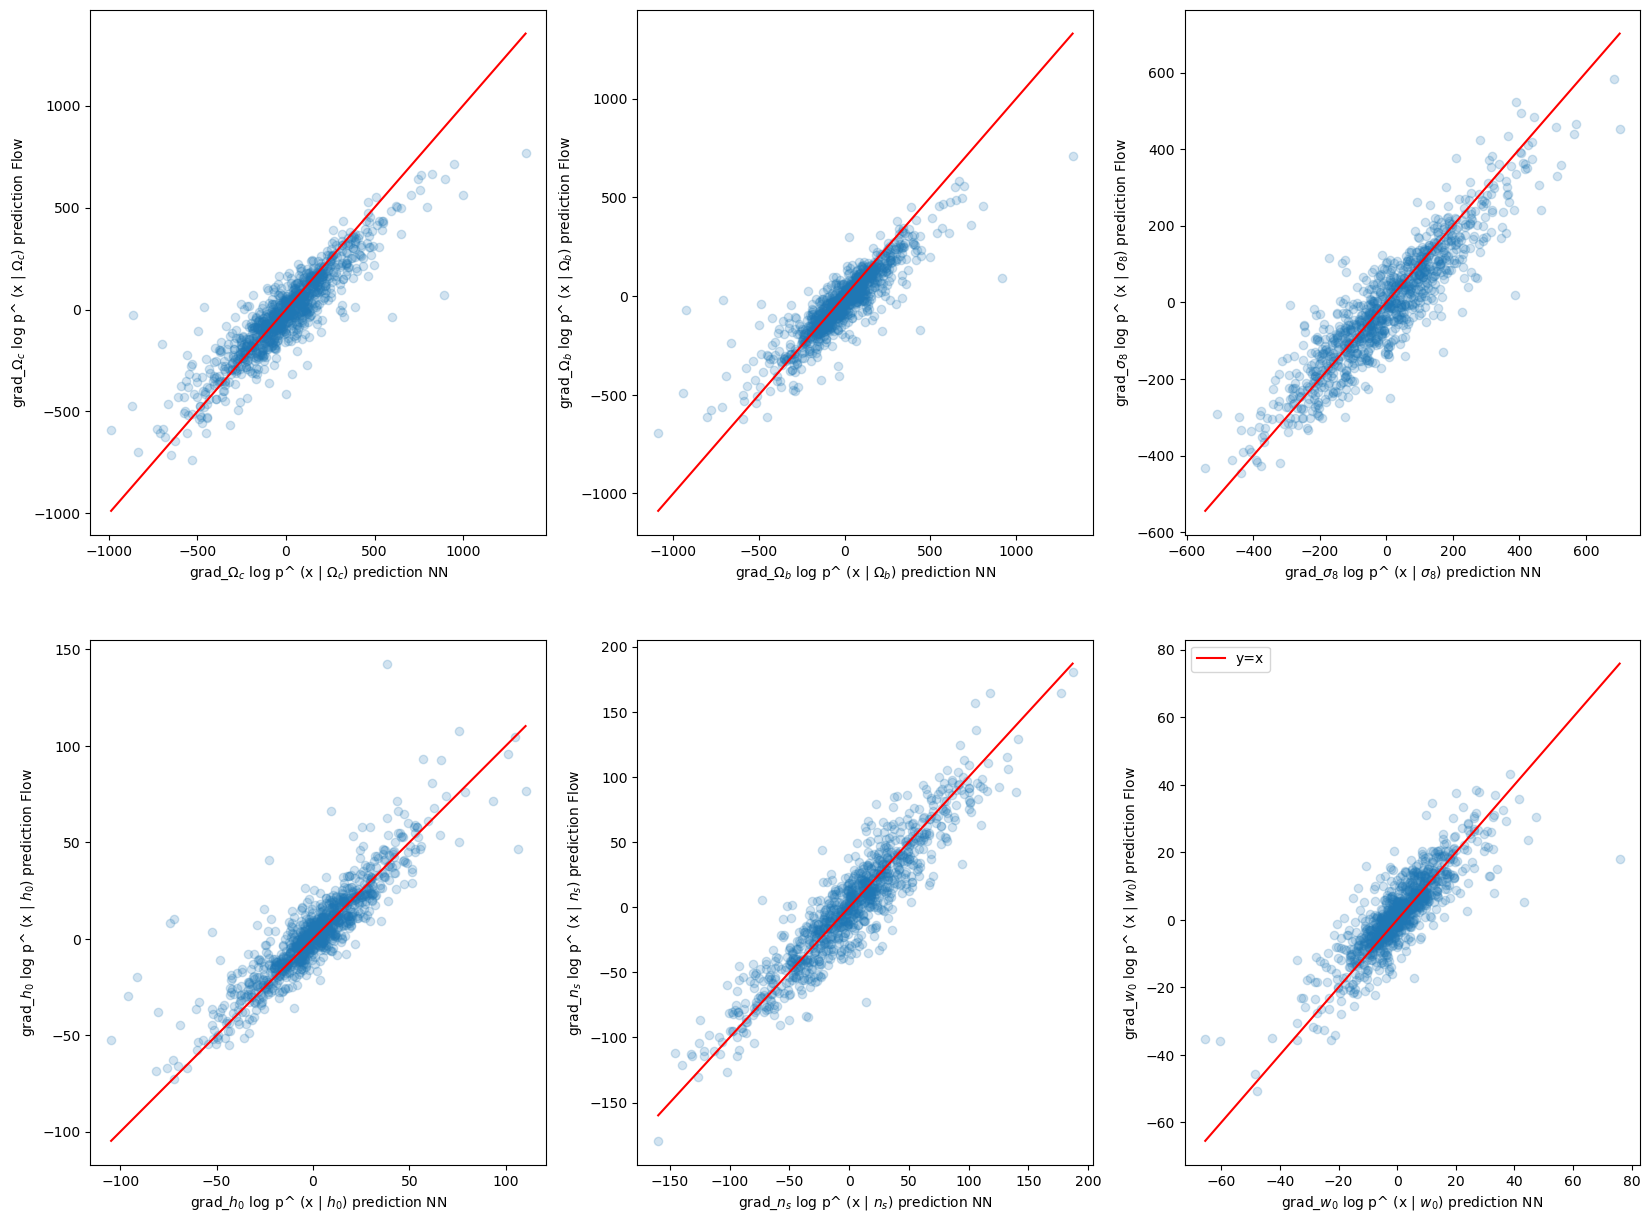

In [24]:
# compare learned marginal score to the gradient of nle

prediction1, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_test[:1000],
    dataset_y_test[:1000]
)

prediction2 = get_marginal_score(dataset_theta_test[:1000], dataset_y_test[:1000])

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(prediction1[...,i], prediction2[...,i], alpha = 0.2)
  min_pred = min(prediction1[...,i])
  max_pred = max(prediction1[...,i])
  plt.plot(jnp.linspace(min_pred, max_pred, 1000), jnp.linspace(min_pred, max_pred, 1000), color = 'red', label = 'y=x')
  plt.xlabel('grad_{} log p^ (x | {}) prediction NN'.format(params_name[i], params_name[i]))
  plt.ylabel('grad_{} log p^ (x | {}) prediction Flow'.format(params_name[i], params_name[i]))

plt.legend()

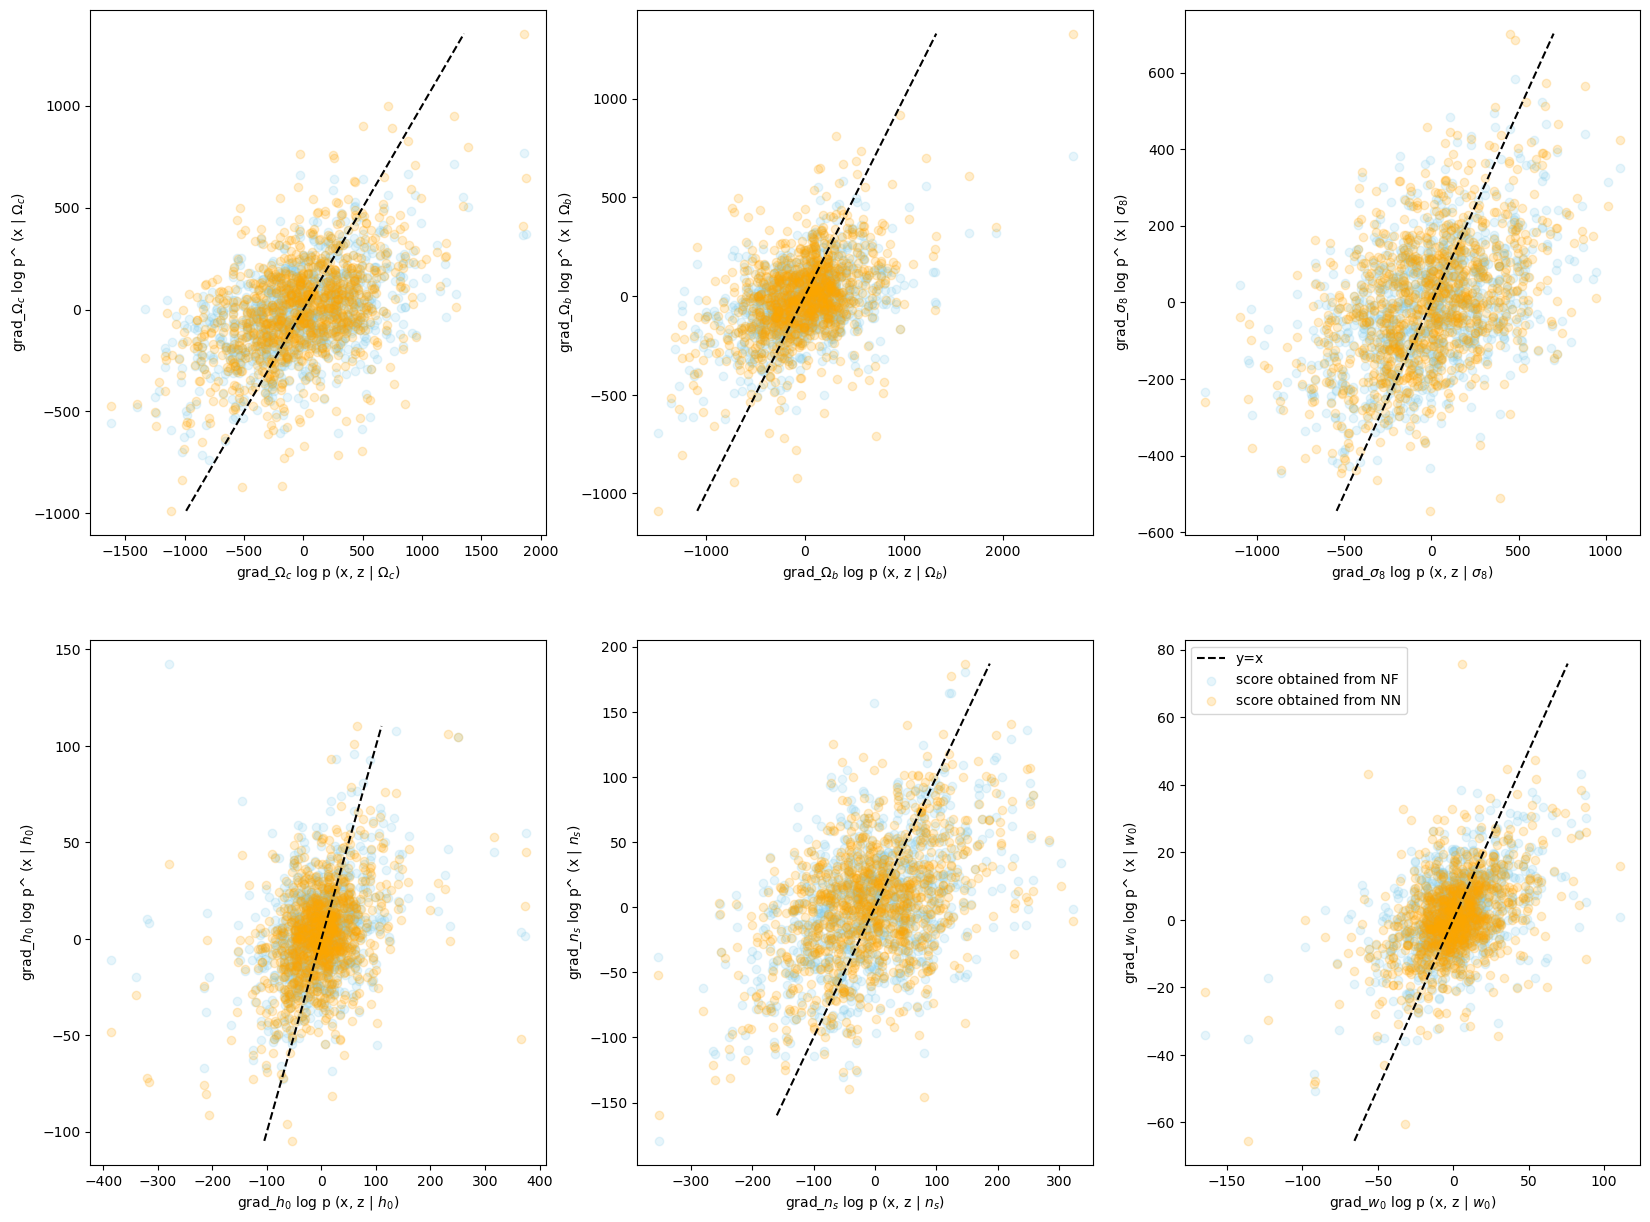

In [25]:
###### check regression on train set

prediction2, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_test[:1000],
    dataset_y_test[:1000]
)

prediction1 = get_marginal_score(dataset_theta_test[:1000], dataset_y_test[:1000])

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)

  plt.scatter(dataset_score_test[:1000][...,i], prediction1[...,i], alpha = 0.2, color = 'skyblue', label = 'score obtained from NF')

  plt.scatter(dataset_score_test[:1000][...,i], prediction2[...,i], alpha = 0.2, color = 'orange', label = 'score obtained from NN')
  
  min_pred = min(prediction2[...,i])
  max_pred = max(prediction2[...,i])
  plt.plot(jnp.linspace(min_pred, max_pred, 1000), jnp.linspace(min_pred, max_pred, 1000), color = 'black', linestyle = '--', label = 'y=x')
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))

plt.legend()